# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import sys
print(sys.path)
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

['', '/home/carnd/anaconda3/envs/dl/lib/python35.zip', '/home/carnd/anaconda3/envs/dl/lib/python3.5', '/home/carnd/anaconda3/envs/dl/lib/python3.5/plat-linux', '/home/carnd/anaconda3/envs/dl/lib/python3.5/lib-dynload', '/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages', '/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/cycler-0.10.0-py3.5.egg', '/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/IPython/extensions', '/home/carnd/.ipython']
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

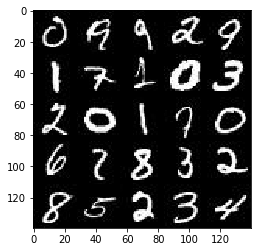

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

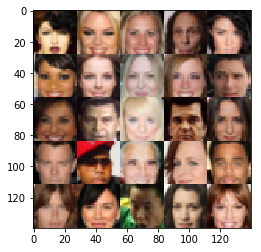

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, n_units=128):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Image layer is 28x28x3
        x1 = tf.layers.conv2d(images,
                              n_units,
                              5,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        # Leaky RelU Per Intro To Gan
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14xn_units
        
        x2 = tf.layers.conv2d(relu1,
                              n_units*2,
                              5,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x(n_units*2)

        x3 = tf.layers.conv2d(relu2,
                              n_units*4,
                              5,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 4x4x(n_units*4)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*4*n_units))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
      
    return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, n_units=128):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*4*n_units)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 4*n_units))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7xn_units*4
        
        x2 = tf.layers.conv2d_transpose(x1,
                                        2*n_units,
                                        5,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14xn_units*2
        
                
        x3 = tf.layers.conv2d_transpose(x2,
                                        n_units,
                                        5,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3,
                                            out_channel_dim,
                                            3,
                                            strides=1,
                                            padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        # 24x24x5
        out = tf.tanh(logits)
        
    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Basically from Intro to GAN
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_logits_real) * (1 - smooth)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_logits_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_logits_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Basically from the Intro to GAN 
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Ensure the generator is updated before the optimization
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates  = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, _learning_rate = model_inputs(image_width,
                                                       image_height,
                                                       image_channels,
                                                       z_dim)

    d_loss, g_loss = model_loss(input_real,
                                input_z,
                                image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss,
                                         g_loss,
                                         _learning_rate,
                                         beta1)
    
    batch_i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Sample random noise for G
                batch_z = np.random.uniform(-1,
                                            1,
                                            size=(batch_size, z_dim))
            
                batch_images = 2 * batch_images
                
                # Run optimizers
                _ = sess.run(d_train_opt,
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        _learning_rate: learning_rate
                    }
                )
                _ = sess.run(g_train_opt,
                    feed_dict={
                        input_z: batch_z,
                        _learning_rate: learning_rate
                    }
                )
                
                batch_i = (batch_i + 1)
                sys.stdout.write("\rBatch {}".format(batch_i))
                if (batch_i % 10) == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    sys.stdout.write("\r")
                    print(
                        "Batch {}...".format(batch_i),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                if (batch_i % 100) == 0:
                    sys.stdout.write("")
                    show_generator_output(sess,
                                          49,
                                          input_z,
                                          image_channels,
                                          data_image_mode)                   
                
            # Always show the generator output at the
            # end of all batches, unless we just displayed it
            if (batch_i % 100) != 0:
                show_generator_output(sess,
                                      49,
                                      input_z,
                                      image_channels,
                                      data_image_mode)
        
            # At the end of each epoch, get the losses and print them out
            train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})
                    
            print(
                "Epoch {}/{}...".format(epoch_i+1, epochs),
                "Discriminator Loss: {:.4f}...".format(train_loss_d),
                "Generator Loss: {:.4f}".format(train_loss_g)
            )

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch 10... Discriminator Loss: 1.8473... Generator Loss: 0.3621
Batch 20... Discriminator Loss: 1.8142... Generator Loss: 2.6345
Batch 30... Discriminator Loss: 1.0732... Generator Loss: 1.1894
Batch 40... Discriminator Loss: 1.7853... Generator Loss: 0.4807
Batch 50... Discriminator Loss: 2.9325... Generator Loss: 0.1125
Batch 60... Discriminator Loss: 1.4365... Generator Loss: 0.8819
Batch 70... Discriminator Loss: 1.3885... Generator Loss: 0.7904
Batch 80... Discriminator Loss: 1.6088... Generator Loss: 1.5478
Batch 90... Discriminator Loss: 1.2848... Generator Loss: 1.2336
Batch 100... Discriminator Loss: 1.5263... Generator Loss: 0.5199


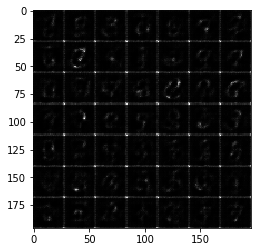

Batch 110... Discriminator Loss: 1.2338... Generator Loss: 1.0226
Batch 120... Discriminator Loss: 1.1812... Generator Loss: 1.5653
Batch 130... Discriminator Loss: 1.4060... Generator Loss: 1.4145
Batch 140... Discriminator Loss: 1.2938... Generator Loss: 0.7060
Batch 150... Discriminator Loss: 1.1329... Generator Loss: 1.1586
Batch 160... Discriminator Loss: 1.2483... Generator Loss: 0.7083
Batch 170... Discriminator Loss: 1.4513... Generator Loss: 0.5243
Batch 180... Discriminator Loss: 0.9836... Generator Loss: 1.2691
Batch 190... Discriminator Loss: 0.9663... Generator Loss: 1.3269
Batch 200... Discriminator Loss: 0.9832... Generator Loss: 1.3657


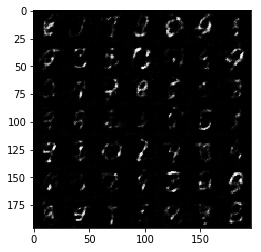

Batch 210... Discriminator Loss: 1.0117... Generator Loss: 1.6549
Batch 220... Discriminator Loss: 1.1122... Generator Loss: 0.8485
Batch 230... Discriminator Loss: 1.1187... Generator Loss: 2.4472
Batch 240... Discriminator Loss: 1.0368... Generator Loss: 1.6238
Batch 250... Discriminator Loss: 1.7322... Generator Loss: 0.3388
Batch 260... Discriminator Loss: 1.0206... Generator Loss: 1.1391
Batch 270... Discriminator Loss: 1.4820... Generator Loss: 0.5363
Batch 280... Discriminator Loss: 1.3455... Generator Loss: 0.6167
Batch 290... Discriminator Loss: 1.0995... Generator Loss: 1.0040
Batch 300... Discriminator Loss: 1.4616... Generator Loss: 0.4752


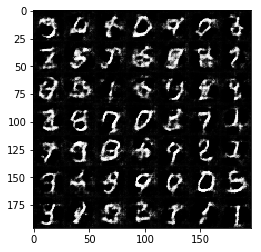

Batch 310... Discriminator Loss: 1.1698... Generator Loss: 0.9221
Batch 320... Discriminator Loss: 1.1286... Generator Loss: 1.0195
Batch 330... Discriminator Loss: 1.5412... Generator Loss: 2.3180
Batch 340... Discriminator Loss: 1.4415... Generator Loss: 0.4949
Batch 350... Discriminator Loss: 1.3408... Generator Loss: 0.5897
Batch 360... Discriminator Loss: 1.3055... Generator Loss: 0.6527
Batch 370... Discriminator Loss: 1.2242... Generator Loss: 0.6700
Batch 380... Discriminator Loss: 1.0440... Generator Loss: 0.9977
Batch 390... Discriminator Loss: 1.6396... Generator Loss: 0.3992
Batch 400... Discriminator Loss: 1.1388... Generator Loss: 0.8169


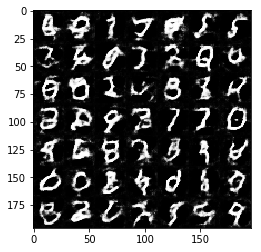

Batch 410... Discriminator Loss: 1.5402... Generator Loss: 0.4147
Batch 420... Discriminator Loss: 1.1494... Generator Loss: 1.0304
Batch 430... Discriminator Loss: 1.0906... Generator Loss: 1.0189
Batch 440... Discriminator Loss: 1.6362... Generator Loss: 0.3823
Batch 450... Discriminator Loss: 1.1326... Generator Loss: 0.9727
Batch 460... Discriminator Loss: 1.2150... Generator Loss: 0.7002
Batch 470... Discriminator Loss: 1.1104... Generator Loss: 0.9619
Batch 480... Discriminator Loss: 1.2555... Generator Loss: 0.6282
Batch 490... Discriminator Loss: 1.1665... Generator Loss: 1.5067
Batch 500... Discriminator Loss: 1.2433... Generator Loss: 0.6800


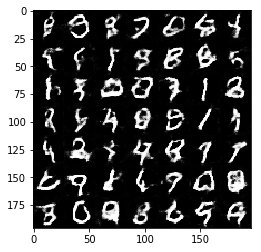

Batch 510... Discriminator Loss: 1.3317... Generator Loss: 0.6090
Batch 520... Discriminator Loss: 1.5439... Generator Loss: 2.4849
Batch 530... Discriminator Loss: 1.0513... Generator Loss: 1.0134
Batch 540... Discriminator Loss: 1.0878... Generator Loss: 1.7482
Batch 550... Discriminator Loss: 1.1035... Generator Loss: 1.0428
Batch 560... Discriminator Loss: 1.1746... Generator Loss: 0.8212
Batch 570... Discriminator Loss: 1.2263... Generator Loss: 1.8027
Batch 580... Discriminator Loss: 1.0069... Generator Loss: 0.9795
Batch 590... Discriminator Loss: 1.2153... Generator Loss: 0.6703
Batch 600... Discriminator Loss: 1.1434... Generator Loss: 0.8040


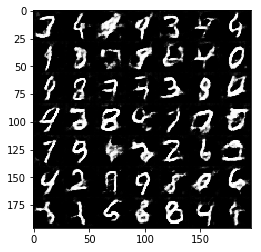

Batch 610... Discriminator Loss: 1.4318... Generator Loss: 0.4886
Batch 620... Discriminator Loss: 1.3085... Generator Loss: 0.5850
Batch 630... Discriminator Loss: 1.2043... Generator Loss: 2.0562
Batch 640... Discriminator Loss: 1.3621... Generator Loss: 0.5281
Batch 650... Discriminator Loss: 1.2306... Generator Loss: 0.7068
Batch 660... Discriminator Loss: 0.9302... Generator Loss: 1.3754
Batch 670... Discriminator Loss: 1.0292... Generator Loss: 1.2878
Batch 680... Discriminator Loss: 1.4961... Generator Loss: 0.4275
Batch 690... Discriminator Loss: 1.1382... Generator Loss: 0.8638
Batch 700... Discriminator Loss: 0.9782... Generator Loss: 1.1238


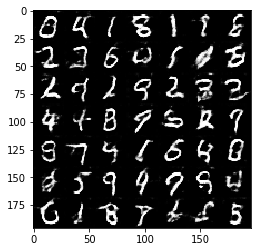

Batch 710... Discriminator Loss: 1.3836... Generator Loss: 0.5354
Batch 720... Discriminator Loss: 0.9800... Generator Loss: 1.5529
Batch 730... Discriminator Loss: 1.4266... Generator Loss: 0.6247
Batch 740... Discriminator Loss: 1.3340... Generator Loss: 1.7905
Batch 750... Discriminator Loss: 1.1403... Generator Loss: 0.7422
Batch 760... Discriminator Loss: 1.2639... Generator Loss: 0.6893
Batch 770... Discriminator Loss: 0.8808... Generator Loss: 1.3682
Batch 780... Discriminator Loss: 1.5068... Generator Loss: 0.4535
Batch 790... Discriminator Loss: 0.8976... Generator Loss: 1.1777
Batch 800... Discriminator Loss: 1.2106... Generator Loss: 0.6710


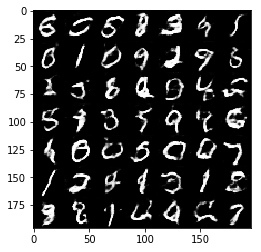

Batch 810... Discriminator Loss: 1.1240... Generator Loss: 0.8599
Batch 820... Discriminator Loss: 0.9440... Generator Loss: 1.3284
Batch 830... Discriminator Loss: 0.9415... Generator Loss: 1.2120
Batch 840... Discriminator Loss: 1.4848... Generator Loss: 0.5396
Batch 850... Discriminator Loss: 0.9463... Generator Loss: 1.2194
Batch 860... Discriminator Loss: 1.1428... Generator Loss: 0.7552
Batch 870... Discriminator Loss: 1.0538... Generator Loss: 1.7568
Batch 880... Discriminator Loss: 1.0642... Generator Loss: 0.8515
Batch 890... Discriminator Loss: 1.7793... Generator Loss: 0.3604
Batch 900... Discriminator Loss: 1.1173... Generator Loss: 0.7483


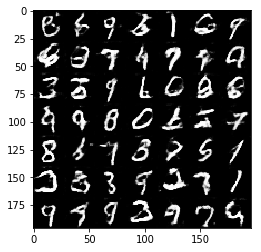

Batch 910... Discriminator Loss: 1.0750... Generator Loss: 0.8670
Batch 920... Discriminator Loss: 1.1140... Generator Loss: 0.9685
Batch 930... Discriminator Loss: 1.1361... Generator Loss: 1.6535
Batch 937

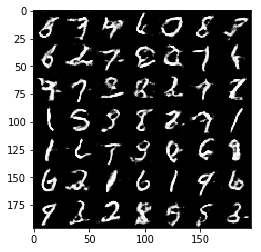

Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 1.6280
Batch 940... Discriminator Loss: 1.1140... Generator Loss: 0.7773
Batch 950... Discriminator Loss: 1.0655... Generator Loss: 1.2378
Batch 960... Discriminator Loss: 0.8828... Generator Loss: 1.2901
Batch 970... Discriminator Loss: 1.3104... Generator Loss: 0.5577
Batch 980... Discriminator Loss: 1.4178... Generator Loss: 0.4901
Batch 990... Discriminator Loss: 1.0066... Generator Loss: 1.6991
Batch 1000... Discriminator Loss: 1.1790... Generator Loss: 0.7203


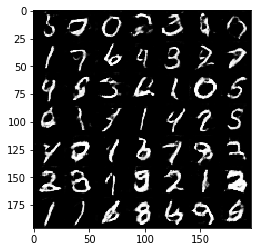

Batch 1010... Discriminator Loss: 1.0031... Generator Loss: 0.9712
Batch 1020... Discriminator Loss: 0.9339... Generator Loss: 1.4666
Batch 1030... Discriminator Loss: 1.5106... Generator Loss: 0.4375
Batch 1040... Discriminator Loss: 0.9620... Generator Loss: 1.1848
Batch 1050... Discriminator Loss: 0.9153... Generator Loss: 1.2340
Batch 1060... Discriminator Loss: 1.1073... Generator Loss: 1.7125
Batch 1070... Discriminator Loss: 1.1969... Generator Loss: 0.7943
Batch 1080... Discriminator Loss: 1.0755... Generator Loss: 0.9805
Batch 1090... Discriminator Loss: 1.1591... Generator Loss: 2.0883
Batch 1100... Discriminator Loss: 1.1025... Generator Loss: 0.7635


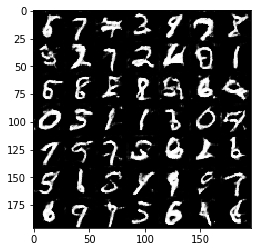

Batch 1110... Discriminator Loss: 0.9590... Generator Loss: 1.0266
Batch 1120... Discriminator Loss: 1.1172... Generator Loss: 0.7209
Batch 1130... Discriminator Loss: 0.9308... Generator Loss: 1.2258
Batch 1140... Discriminator Loss: 1.3705... Generator Loss: 0.5406
Batch 1150... Discriminator Loss: 1.1666... Generator Loss: 0.7105
Batch 1160... Discriminator Loss: 1.3223... Generator Loss: 0.5468
Batch 1170... Discriminator Loss: 1.1220... Generator Loss: 1.5613
Batch 1180... Discriminator Loss: 1.1510... Generator Loss: 0.7660
Batch 1190... Discriminator Loss: 1.3445... Generator Loss: 2.3511
Batch 1200... Discriminator Loss: 1.3864... Generator Loss: 0.5211


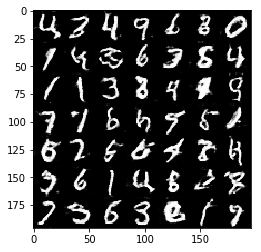

Batch 1210... Discriminator Loss: 1.0918... Generator Loss: 1.5469
Batch 1220... Discriminator Loss: 1.0334... Generator Loss: 0.8972
Batch 1230... Discriminator Loss: 1.0492... Generator Loss: 0.8844
Batch 1240... Discriminator Loss: 1.2217... Generator Loss: 0.6223
Batch 1250... Discriminator Loss: 1.0340... Generator Loss: 1.4872
Batch 1260... Discriminator Loss: 1.0049... Generator Loss: 1.6369
Batch 1270... Discriminator Loss: 1.2364... Generator Loss: 2.2723
Batch 1280... Discriminator Loss: 1.3886... Generator Loss: 0.5089
Batch 1290... Discriminator Loss: 0.9433... Generator Loss: 1.0631
Batch 1300... Discriminator Loss: 0.8557... Generator Loss: 1.1605


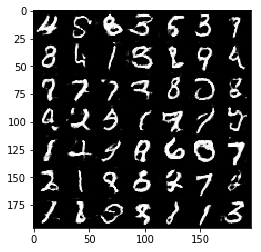

Batch 1310... Discriminator Loss: 0.9233... Generator Loss: 1.3402
Batch 1320... Discriminator Loss: 1.0031... Generator Loss: 1.5028
Batch 1330... Discriminator Loss: 0.8841... Generator Loss: 1.1403
Batch 1340... Discriminator Loss: 1.1134... Generator Loss: 0.7936
Batch 1350... Discriminator Loss: 1.2120... Generator Loss: 2.2301
Batch 1360... Discriminator Loss: 0.8869... Generator Loss: 1.8861
Batch 1370... Discriminator Loss: 1.2122... Generator Loss: 1.6638
Batch 1380... Discriminator Loss: 1.1191... Generator Loss: 1.7106
Batch 1390... Discriminator Loss: 1.1225... Generator Loss: 0.8275
Batch 1400... Discriminator Loss: 0.8673... Generator Loss: 2.0041


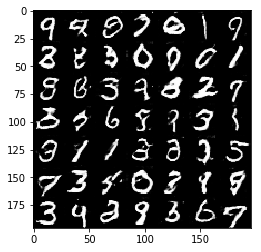

Batch 1410... Discriminator Loss: 0.7786... Generator Loss: 1.4653
Batch 1420... Discriminator Loss: 0.9762... Generator Loss: 1.4351
Batch 1430... Discriminator Loss: 1.9253... Generator Loss: 3.4199
Batch 1440... Discriminator Loss: 1.1432... Generator Loss: 0.7717
Batch 1450... Discriminator Loss: 0.9038... Generator Loss: 1.5438
Batch 1460... Discriminator Loss: 1.0791... Generator Loss: 0.8557
Batch 1470... Discriminator Loss: 0.8494... Generator Loss: 1.6674
Batch 1480... Discriminator Loss: 2.2020... Generator Loss: 0.2554
Batch 1490... Discriminator Loss: 0.8980... Generator Loss: 1.3613
Batch 1500... Discriminator Loss: 1.0882... Generator Loss: 0.8092


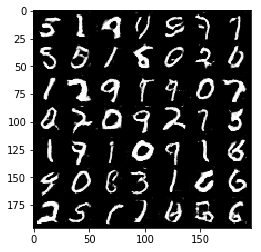

Batch 1510... Discriminator Loss: 1.5711... Generator Loss: 0.4387
Batch 1520... Discriminator Loss: 0.8899... Generator Loss: 1.1725
Batch 1530... Discriminator Loss: 0.8672... Generator Loss: 1.1829
Batch 1540... Discriminator Loss: 0.9342... Generator Loss: 1.0529
Batch 1550... Discriminator Loss: 1.3992... Generator Loss: 0.6909
Batch 1560... Discriminator Loss: 1.0532... Generator Loss: 2.3722
Batch 1570... Discriminator Loss: 1.0524... Generator Loss: 1.7170
Batch 1580... Discriminator Loss: 1.1005... Generator Loss: 0.7812
Batch 1590... Discriminator Loss: 0.9139... Generator Loss: 1.0928
Batch 1600... Discriminator Loss: 1.1801... Generator Loss: 0.7554


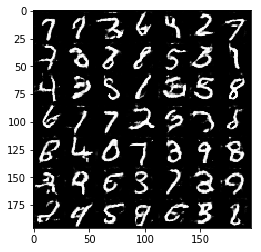

Batch 1610... Discriminator Loss: 1.1035... Generator Loss: 0.7757
Batch 1620... Discriminator Loss: 1.0977... Generator Loss: 2.0051
Batch 1630... Discriminator Loss: 0.8326... Generator Loss: 1.6020
Batch 1640... Discriminator Loss: 0.7364... Generator Loss: 1.4138
Batch 1650... Discriminator Loss: 1.4723... Generator Loss: 0.5033
Batch 1660... Discriminator Loss: 0.9779... Generator Loss: 1.2164
Batch 1670... Discriminator Loss: 1.2632... Generator Loss: 0.6305
Batch 1680... Discriminator Loss: 0.8889... Generator Loss: 1.1480
Batch 1690... Discriminator Loss: 1.2796... Generator Loss: 2.6995
Batch 1700... Discriminator Loss: 1.6782... Generator Loss: 0.3834


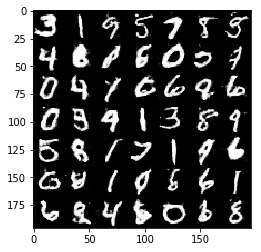

Batch 1710... Discriminator Loss: 0.9761... Generator Loss: 1.0286
Batch 1720... Discriminator Loss: 1.0414... Generator Loss: 0.8721
Batch 1730... Discriminator Loss: 1.1506... Generator Loss: 0.7617
Batch 1740... Discriminator Loss: 0.9684... Generator Loss: 1.1971
Batch 1750... Discriminator Loss: 0.8421... Generator Loss: 1.2513
Batch 1760... Discriminator Loss: 1.1083... Generator Loss: 0.8229
Batch 1770... Discriminator Loss: 1.1344... Generator Loss: 0.7117
Batch 1780... Discriminator Loss: 1.0278... Generator Loss: 1.0354
Batch 1790... Discriminator Loss: 0.9703... Generator Loss: 1.2810
Batch 1800... Discriminator Loss: 0.8897... Generator Loss: 1.1714


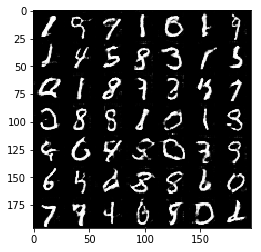

Batch 1810... Discriminator Loss: 0.9788... Generator Loss: 1.0240
Batch 1820... Discriminator Loss: 0.9434... Generator Loss: 1.3278
Batch 1830... Discriminator Loss: 1.4158... Generator Loss: 0.5139
Batch 1840... Discriminator Loss: 0.8661... Generator Loss: 1.4520
Batch 1850... Discriminator Loss: 0.8363... Generator Loss: 1.8382
Batch 1860... Discriminator Loss: 0.7817... Generator Loss: 1.5530
Batch 1870... Discriminator Loss: 0.8741... Generator Loss: 1.1702
Batch 1874

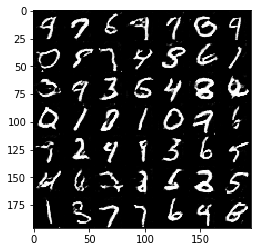

Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 1.3783


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch 10... Discriminator Loss: 2.4954... Generator Loss: 0.2179
Batch 20... Discriminator Loss: 0.8744... Generator Loss: 1.5877
Batch 30... Discriminator Loss: 0.6636... Generator Loss: 1.7633
Batch 40... Discriminator Loss: 1.0119... Generator Loss: 5.0973
Batch 50... Discriminator Loss: 1.5400... Generator Loss: 0.5086
Batch 60... Discriminator Loss: 2.7717... Generator Loss: 0.1664
Batch 70... Discriminator Loss: 0.6503... Generator Loss: 2.4896
Batch 80... Discriminator Loss: 2.5704... Generator Loss: 0.1438
Batch 90... Discriminator Loss: 0.6202... Generator Loss: 2.5219
Batch 100... Discriminator Loss: 0.8359... Generator Loss: 1.1512


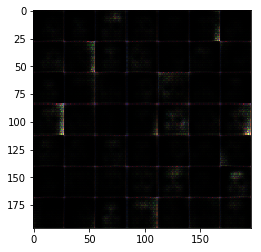

Batch 110... Discriminator Loss: 0.7655... Generator Loss: 1.5887
Batch 120... Discriminator Loss: 1.7011... Generator Loss: 0.4738
Batch 130... Discriminator Loss: 2.2955... Generator Loss: 0.2008
Batch 140... Discriminator Loss: 0.4648... Generator Loss: 3.2295
Batch 150... Discriminator Loss: 2.5736... Generator Loss: 7.9173
Batch 160... Discriminator Loss: 1.3571... Generator Loss: 0.6622
Batch 170... Discriminator Loss: 2.1355... Generator Loss: 0.2846
Batch 180... Discriminator Loss: 2.2651... Generator Loss: 0.2461
Batch 190... Discriminator Loss: 1.8319... Generator Loss: 2.1773
Batch 200... Discriminator Loss: 1.0665... Generator Loss: 3.7314


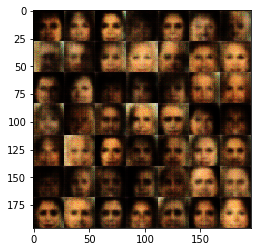

Batch 210... Discriminator Loss: 1.4242... Generator Loss: 0.5274
Batch 220... Discriminator Loss: 0.4439... Generator Loss: 2.7463
Batch 230... Discriminator Loss: 0.9268... Generator Loss: 1.3934
Batch 240... Discriminator Loss: 0.6216... Generator Loss: 7.9582
Batch 250... Discriminator Loss: 1.6576... Generator Loss: 0.4108
Batch 260... Discriminator Loss: 0.8327... Generator Loss: 1.3032
Batch 270... Discriminator Loss: 0.6955... Generator Loss: 1.6205
Batch 280... Discriminator Loss: 0.4147... Generator Loss: 4.8216
Batch 290... Discriminator Loss: 0.4189... Generator Loss: 3.3152
Batch 300... Discriminator Loss: 0.7183... Generator Loss: 5.6576


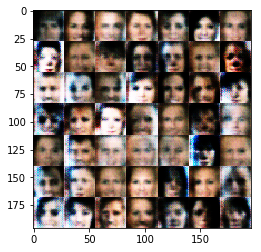

Batch 310... Discriminator Loss: 0.7755... Generator Loss: 1.3162
Batch 320... Discriminator Loss: 2.0509... Generator Loss: 6.9382
Batch 330... Discriminator Loss: 0.4237... Generator Loss: 3.9064
Batch 340... Discriminator Loss: 1.8394... Generator Loss: 0.3056
Batch 350... Discriminator Loss: 1.0333... Generator Loss: 0.8303
Batch 360... Discriminator Loss: 0.7963... Generator Loss: 1.4667
Batch 370... Discriminator Loss: 1.1828... Generator Loss: 0.7678
Batch 380... Discriminator Loss: 1.1830... Generator Loss: 2.4615
Batch 390... Discriminator Loss: 0.6934... Generator Loss: 1.5213
Batch 400... Discriminator Loss: 1.5729... Generator Loss: 0.4004


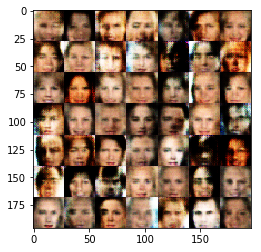

Batch 410... Discriminator Loss: 0.4549... Generator Loss: 4.4709
Batch 420... Discriminator Loss: 1.2377... Generator Loss: 0.6079
Batch 430... Discriminator Loss: 1.7295... Generator Loss: 3.7151
Batch 440... Discriminator Loss: 1.2324... Generator Loss: 1.3503
Batch 450... Discriminator Loss: 1.2849... Generator Loss: 0.5790
Batch 460... Discriminator Loss: 1.8317... Generator Loss: 3.9482
Batch 470... Discriminator Loss: 1.1176... Generator Loss: 1.6293
Batch 480... Discriminator Loss: 1.0097... Generator Loss: 0.8637
Batch 490... Discriminator Loss: 1.5153... Generator Loss: 0.4185
Batch 500... Discriminator Loss: 0.6014... Generator Loss: 3.5906


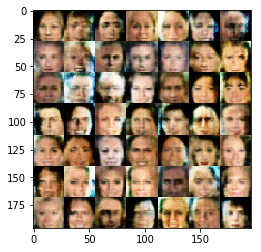

Batch 510... Discriminator Loss: 0.9319... Generator Loss: 1.9092
Batch 520... Discriminator Loss: 0.7049... Generator Loss: 2.8228
Batch 530... Discriminator Loss: 1.1427... Generator Loss: 0.7665
Batch 540... Discriminator Loss: 0.5969... Generator Loss: 2.6489
Batch 550... Discriminator Loss: 1.0772... Generator Loss: 1.0433
Batch 560... Discriminator Loss: 0.6817... Generator Loss: 7.1762
Batch 570... Discriminator Loss: 1.2785... Generator Loss: 0.5472
Batch 580... Discriminator Loss: 2.6310... Generator Loss: 4.0654
Batch 590... Discriminator Loss: 1.2249... Generator Loss: 1.0227
Batch 600... Discriminator Loss: 1.0687... Generator Loss: 1.1739


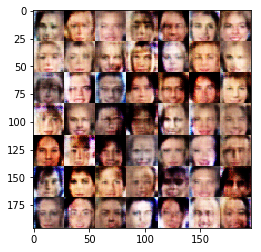

Batch 610... Discriminator Loss: 1.0070... Generator Loss: 3.2927
Batch 620... Discriminator Loss: 0.6276... Generator Loss: 2.1958
Batch 630... Discriminator Loss: 0.4016... Generator Loss: 3.4720
Batch 640... Discriminator Loss: 1.4118... Generator Loss: 0.6047
Batch 650... Discriminator Loss: 1.4806... Generator Loss: 0.5685
Batch 660... Discriminator Loss: 1.3310... Generator Loss: 0.6007
Batch 670... Discriminator Loss: 1.1503... Generator Loss: 1.5303
Batch 680... Discriminator Loss: 0.8844... Generator Loss: 1.1149
Batch 690... Discriminator Loss: 0.6317... Generator Loss: 1.9743
Batch 700... Discriminator Loss: 1.0525... Generator Loss: 0.8736


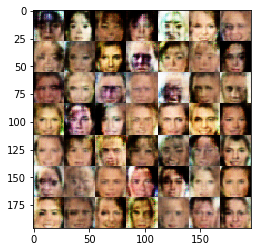

Batch 710... Discriminator Loss: 1.1318... Generator Loss: 0.8013
Batch 720... Discriminator Loss: 0.8523... Generator Loss: 1.8235
Batch 730... Discriminator Loss: 0.6113... Generator Loss: 1.7181
Batch 740... Discriminator Loss: 1.4357... Generator Loss: 1.3181
Batch 750... Discriminator Loss: 0.9639... Generator Loss: 3.2322
Batch 760... Discriminator Loss: 1.2005... Generator Loss: 0.6381
Batch 770... Discriminator Loss: 1.4642... Generator Loss: 0.5902
Batch 780... Discriminator Loss: 1.2984... Generator Loss: 0.5825
Batch 790... Discriminator Loss: 1.4841... Generator Loss: 0.9519
Batch 800... Discriminator Loss: 0.6459... Generator Loss: 1.6477


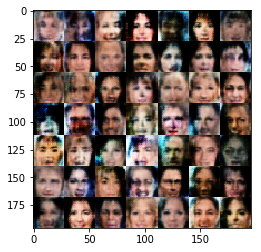

Batch 810... Discriminator Loss: 0.9359... Generator Loss: 0.8879
Batch 820... Discriminator Loss: 1.5572... Generator Loss: 3.8044
Batch 830... Discriminator Loss: 0.6192... Generator Loss: 2.4671
Batch 840... Discriminator Loss: 1.2654... Generator Loss: 0.6148
Batch 850... Discriminator Loss: 1.4482... Generator Loss: 2.5287
Batch 860... Discriminator Loss: 1.8169... Generator Loss: 2.8601
Batch 870... Discriminator Loss: 0.9706... Generator Loss: 2.5171
Batch 880... Discriminator Loss: 1.6874... Generator Loss: 0.4042
Batch 890... Discriminator Loss: 1.5962... Generator Loss: 0.4343
Batch 900... Discriminator Loss: 1.4389... Generator Loss: 0.7933


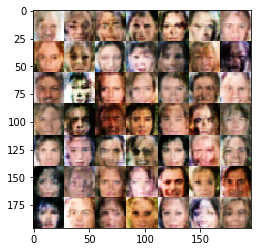

Batch 910... Discriminator Loss: 1.0382... Generator Loss: 1.2194
Batch 920... Discriminator Loss: 0.6631... Generator Loss: 3.0474
Batch 930... Discriminator Loss: 0.7234... Generator Loss: 1.3010
Batch 940... Discriminator Loss: 1.3026... Generator Loss: 0.6453
Batch 950... Discriminator Loss: 1.2092... Generator Loss: 0.8234
Batch 960... Discriminator Loss: 1.1034... Generator Loss: 0.9078
Batch 970... Discriminator Loss: 1.1258... Generator Loss: 1.0226
Batch 980... Discriminator Loss: 1.1348... Generator Loss: 0.7046
Batch 990... Discriminator Loss: 5.0653... Generator Loss: 5.3598
Batch 1000... Discriminator Loss: 1.0953... Generator Loss: 0.7565


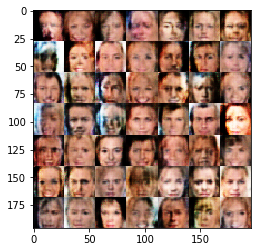

Batch 1010... Discriminator Loss: 1.6610... Generator Loss: 0.3684
Batch 1020... Discriminator Loss: 1.4295... Generator Loss: 0.4347
Batch 1030... Discriminator Loss: 0.9004... Generator Loss: 0.9671
Batch 1040... Discriminator Loss: 1.2298... Generator Loss: 0.8374
Batch 1050... Discriminator Loss: 0.6757... Generator Loss: 1.5637
Batch 1060... Discriminator Loss: 0.7557... Generator Loss: 2.4430
Batch 1070... Discriminator Loss: 1.4521... Generator Loss: 0.4874
Batch 1080... Discriminator Loss: 1.3929... Generator Loss: 0.5759
Batch 1090... Discriminator Loss: 0.6956... Generator Loss: 1.5767
Batch 1100... Discriminator Loss: 1.8076... Generator Loss: 0.3221


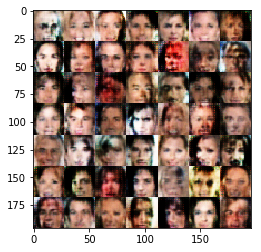

Batch 1110... Discriminator Loss: 1.2210... Generator Loss: 1.3070
Batch 1120... Discriminator Loss: 0.8141... Generator Loss: 2.9464
Batch 1130... Discriminator Loss: 0.7346... Generator Loss: 1.5915
Batch 1140... Discriminator Loss: 0.6451... Generator Loss: 1.7814
Batch 1150... Discriminator Loss: 0.6664... Generator Loss: 2.8004
Batch 1160... Discriminator Loss: 0.8001... Generator Loss: 1.3920
Batch 1170... Discriminator Loss: 1.4060... Generator Loss: 0.8125
Batch 1180... Discriminator Loss: 1.0376... Generator Loss: 1.2028
Batch 1190... Discriminator Loss: 1.4483... Generator Loss: 3.0416
Batch 1200... Discriminator Loss: 1.3931... Generator Loss: 0.5175


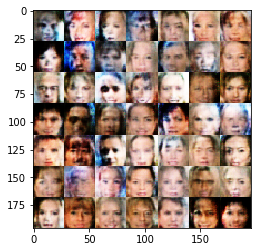

Batch 1210... Discriminator Loss: 0.9471... Generator Loss: 2.1596
Batch 1220... Discriminator Loss: 0.8689... Generator Loss: 3.0447
Batch 1230... Discriminator Loss: 1.1079... Generator Loss: 0.6900
Batch 1240... Discriminator Loss: 0.9065... Generator Loss: 0.9342
Batch 1250... Discriminator Loss: 1.0117... Generator Loss: 1.2019
Batch 1260... Discriminator Loss: 1.3553... Generator Loss: 2.2432
Batch 1270... Discriminator Loss: 1.0262... Generator Loss: 0.8269
Batch 1280... Discriminator Loss: 1.9116... Generator Loss: 3.0940
Batch 1290... Discriminator Loss: 0.9548... Generator Loss: 0.9105
Batch 1300... Discriminator Loss: 0.7964... Generator Loss: 1.5853


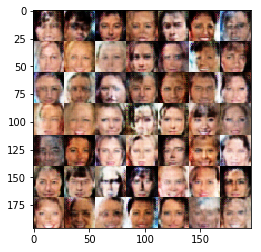

Batch 1310... Discriminator Loss: 0.9347... Generator Loss: 1.0325
Batch 1320... Discriminator Loss: 1.1364... Generator Loss: 1.0153
Batch 1330... Discriminator Loss: 1.7704... Generator Loss: 0.3357
Batch 1340... Discriminator Loss: 1.1463... Generator Loss: 0.9606
Batch 1350... Discriminator Loss: 1.1551... Generator Loss: 0.7464
Batch 1360... Discriminator Loss: 1.7185... Generator Loss: 0.3286
Batch 1370... Discriminator Loss: 0.7985... Generator Loss: 1.3771
Batch 1380... Discriminator Loss: 0.7816... Generator Loss: 1.3022
Batch 1390... Discriminator Loss: 1.0659... Generator Loss: 1.5484
Batch 1400... Discriminator Loss: 1.1791... Generator Loss: 0.6852


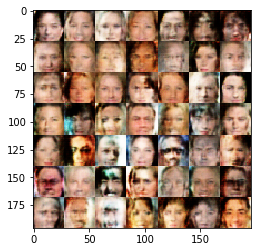

Batch 1410... Discriminator Loss: 1.4034... Generator Loss: 0.5221
Batch 1420... Discriminator Loss: 2.7180... Generator Loss: 0.1426
Batch 1430... Discriminator Loss: 0.7628... Generator Loss: 1.6725
Batch 1440... Discriminator Loss: 0.7598... Generator Loss: 1.6678
Batch 1450... Discriminator Loss: 1.3110... Generator Loss: 0.6989
Batch 1460... Discriminator Loss: 1.0409... Generator Loss: 0.8331
Batch 1470... Discriminator Loss: 1.2800... Generator Loss: 1.1874
Batch 1480... Discriminator Loss: 0.9668... Generator Loss: 0.9300
Batch 1490... Discriminator Loss: 0.8133... Generator Loss: 2.2871
Batch 1500... Discriminator Loss: 0.6473... Generator Loss: 1.5456


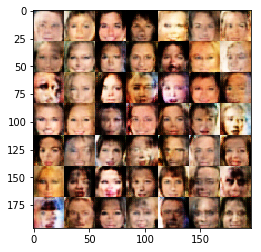

Batch 1510... Discriminator Loss: 1.5830... Generator Loss: 0.4896
Batch 1520... Discriminator Loss: 1.2369... Generator Loss: 0.6346
Batch 1530... Discriminator Loss: 0.8592... Generator Loss: 2.1299
Batch 1540... Discriminator Loss: 1.1831... Generator Loss: 1.7835
Batch 1550... Discriminator Loss: 0.5929... Generator Loss: 2.3038
Batch 1560... Discriminator Loss: 1.4890... Generator Loss: 2.0391
Batch 1570... Discriminator Loss: 1.6508... Generator Loss: 0.3624
Batch 1580... Discriminator Loss: 1.6145... Generator Loss: 0.3796
Batch 1590... Discriminator Loss: 1.1570... Generator Loss: 2.3641
Batch 1600... Discriminator Loss: 1.2124... Generator Loss: 0.7572


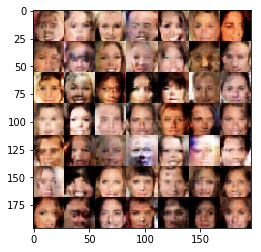

Batch 1610... Discriminator Loss: 1.0650... Generator Loss: 0.7814
Batch 1620... Discriminator Loss: 1.6086... Generator Loss: 0.3741
Batch 1630... Discriminator Loss: 1.2186... Generator Loss: 0.6191
Batch 1640... Discriminator Loss: 1.4431... Generator Loss: 0.5033
Batch 1650... Discriminator Loss: 0.6568... Generator Loss: 1.9111
Batch 1660... Discriminator Loss: 2.0584... Generator Loss: 0.2272
Batch 1670... Discriminator Loss: 1.1879... Generator Loss: 0.8939
Batch 1680... Discriminator Loss: 0.8672... Generator Loss: 1.3671
Batch 1690... Discriminator Loss: 0.9626... Generator Loss: 1.3313
Batch 1700... Discriminator Loss: 1.3564... Generator Loss: 0.5563


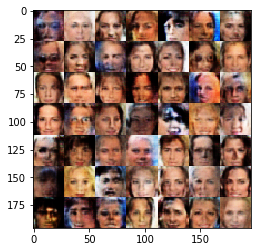

Batch 1710... Discriminator Loss: 0.7778... Generator Loss: 3.5453
Batch 1720... Discriminator Loss: 0.7645... Generator Loss: 2.2174
Batch 1730... Discriminator Loss: 1.1468... Generator Loss: 0.6918
Batch 1740... Discriminator Loss: 1.1805... Generator Loss: 0.6316
Batch 1750... Discriminator Loss: 0.6238... Generator Loss: 2.0872
Batch 1760... Discriminator Loss: 1.2828... Generator Loss: 0.6294
Batch 1770... Discriminator Loss: 0.9428... Generator Loss: 0.9158
Batch 1780... Discriminator Loss: 1.2840... Generator Loss: 1.8664
Batch 1790... Discriminator Loss: 1.0584... Generator Loss: 1.1681
Batch 1800... Discriminator Loss: 0.9866... Generator Loss: 1.7441


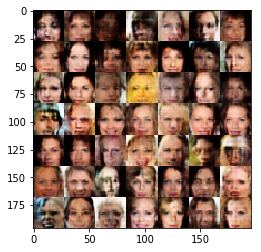

Batch 1810... Discriminator Loss: 0.9845... Generator Loss: 0.9501
Batch 1820... Discriminator Loss: 0.9455... Generator Loss: 1.1632
Batch 1830... Discriminator Loss: 0.7963... Generator Loss: 1.4910
Batch 1840... Discriminator Loss: 1.0534... Generator Loss: 0.8207
Batch 1850... Discriminator Loss: 0.9063... Generator Loss: 0.9788
Batch 1860... Discriminator Loss: 0.5230... Generator Loss: 3.1790
Batch 1870... Discriminator Loss: 1.2984... Generator Loss: 0.5704
Batch 1880... Discriminator Loss: 0.9185... Generator Loss: 1.0838
Batch 1890... Discriminator Loss: 1.1028... Generator Loss: 2.8476
Batch 1900... Discriminator Loss: 1.0078... Generator Loss: 0.8388


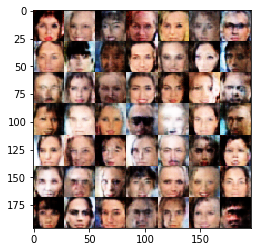

Batch 1910... Discriminator Loss: 1.3376... Generator Loss: 0.5784
Batch 1920... Discriminator Loss: 0.5051... Generator Loss: 2.2028
Batch 1930... Discriminator Loss: 1.8755... Generator Loss: 0.2825
Batch 1940... Discriminator Loss: 0.8198... Generator Loss: 1.1891
Batch 1950... Discriminator Loss: 1.2207... Generator Loss: 1.8170
Batch 1960... Discriminator Loss: 1.3855... Generator Loss: 0.5177
Batch 1970... Discriminator Loss: 1.5835... Generator Loss: 0.4037
Batch 1980... Discriminator Loss: 0.9153... Generator Loss: 2.2909
Batch 1990... Discriminator Loss: 1.7395... Generator Loss: 0.3423
Batch 2000... Discriminator Loss: 1.1398... Generator Loss: 1.2051


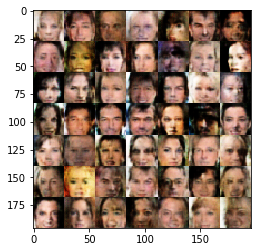

Batch 2010... Discriminator Loss: 1.1638... Generator Loss: 0.7840
Batch 2020... Discriminator Loss: 1.1694... Generator Loss: 1.1984
Batch 2030... Discriminator Loss: 1.1168... Generator Loss: 1.8961
Batch 2040... Discriminator Loss: 0.7939... Generator Loss: 1.5519
Batch 2050... Discriminator Loss: 1.3167... Generator Loss: 1.4138
Batch 2060... Discriminator Loss: 1.0747... Generator Loss: 1.0964
Batch 2070... Discriminator Loss: 0.9670... Generator Loss: 1.4798
Batch 2080... Discriminator Loss: 1.3755... Generator Loss: 1.5768
Batch 2090... Discriminator Loss: 1.0481... Generator Loss: 0.9885
Batch 2100... Discriminator Loss: 1.8695... Generator Loss: 3.5210


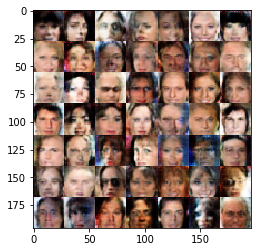

Batch 2110... Discriminator Loss: 0.7563... Generator Loss: 1.2849
Batch 2120... Discriminator Loss: 0.8249... Generator Loss: 1.1121
Batch 2130... Discriminator Loss: 1.3787... Generator Loss: 0.5827
Batch 2140... Discriminator Loss: 0.8201... Generator Loss: 1.4250
Batch 2150... Discriminator Loss: 1.5772... Generator Loss: 0.4087
Batch 2160... Discriminator Loss: 0.9679... Generator Loss: 1.1162
Batch 2170... Discriminator Loss: 1.5463... Generator Loss: 1.6330
Batch 2180... Discriminator Loss: 1.3100... Generator Loss: 2.3708
Batch 2190... Discriminator Loss: 0.9980... Generator Loss: 1.5434
Batch 2200... Discriminator Loss: 1.3519... Generator Loss: 1.2303


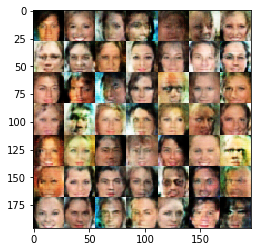

Batch 2210... Discriminator Loss: 0.5798... Generator Loss: 2.2924
Batch 2220... Discriminator Loss: 1.1608... Generator Loss: 0.8844
Batch 2230... Discriminator Loss: 0.9395... Generator Loss: 0.9178
Batch 2240... Discriminator Loss: 0.9961... Generator Loss: 0.9285
Batch 2250... Discriminator Loss: 1.0145... Generator Loss: 2.2456
Batch 2260... Discriminator Loss: 0.8970... Generator Loss: 1.1060
Batch 2270... Discriminator Loss: 1.5432... Generator Loss: 2.4903
Batch 2280... Discriminator Loss: 0.6186... Generator Loss: 2.0517
Batch 2290... Discriminator Loss: 1.0937... Generator Loss: 1.0092
Batch 2300... Discriminator Loss: 0.6643... Generator Loss: 1.7190


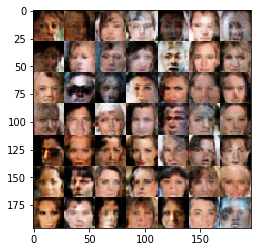

Batch 2310... Discriminator Loss: 1.0431... Generator Loss: 0.8910
Batch 2320... Discriminator Loss: 0.4987... Generator Loss: 2.5073
Batch 2330... Discriminator Loss: 2.0580... Generator Loss: 0.2349
Batch 2340... Discriminator Loss: 0.8202... Generator Loss: 3.3015
Batch 2350... Discriminator Loss: 1.7272... Generator Loss: 0.3665
Batch 2360... Discriminator Loss: 0.8009... Generator Loss: 1.2937
Batch 2370... Discriminator Loss: 1.1529... Generator Loss: 0.8224
Batch 2380... Discriminator Loss: 1.5204... Generator Loss: 0.4184
Batch 2390... Discriminator Loss: 1.1662... Generator Loss: 1.0126
Batch 2400... Discriminator Loss: 1.1055... Generator Loss: 0.8699


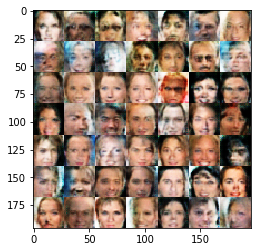

Batch 2410... Discriminator Loss: 1.3118... Generator Loss: 0.5867
Batch 2420... Discriminator Loss: 0.9752... Generator Loss: 0.9416
Batch 2430... Discriminator Loss: 1.5919... Generator Loss: 0.3741
Batch 2440... Discriminator Loss: 0.9034... Generator Loss: 1.1994
Batch 2450... Discriminator Loss: 0.7277... Generator Loss: 1.3498
Batch 2460... Discriminator Loss: 1.5519... Generator Loss: 0.4790
Batch 2470... Discriminator Loss: 0.9035... Generator Loss: 1.0169
Batch 2480... Discriminator Loss: 1.3038... Generator Loss: 0.6258
Batch 2490... Discriminator Loss: 1.2657... Generator Loss: 0.6001
Batch 2500... Discriminator Loss: 1.6493... Generator Loss: 0.3669


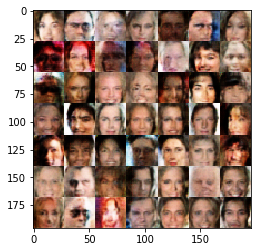

Batch 2510... Discriminator Loss: 1.3524... Generator Loss: 0.6111
Batch 2520... Discriminator Loss: 1.9047... Generator Loss: 3.9343
Batch 2530... Discriminator Loss: 1.0417... Generator Loss: 0.9170
Batch 2540... Discriminator Loss: 0.8961... Generator Loss: 1.1459
Batch 2550... Discriminator Loss: 1.5126... Generator Loss: 0.4523
Batch 2560... Discriminator Loss: 1.1065... Generator Loss: 3.9447
Batch 2570... Discriminator Loss: 1.1909... Generator Loss: 0.6348
Batch 2580... Discriminator Loss: 1.3332... Generator Loss: 1.3236
Batch 2590... Discriminator Loss: 0.7892... Generator Loss: 1.4476
Batch 2600... Discriminator Loss: 0.7496... Generator Loss: 2.5894


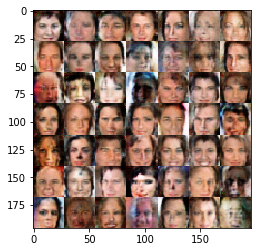

Batch 2610... Discriminator Loss: 1.2822... Generator Loss: 0.9412
Batch 2620... Discriminator Loss: 1.1881... Generator Loss: 0.6298
Batch 2630... Discriminator Loss: 0.9550... Generator Loss: 1.1388
Batch 2640... Discriminator Loss: 1.3261... Generator Loss: 1.0214
Batch 2650... Discriminator Loss: 1.1579... Generator Loss: 0.7309
Batch 2660... Discriminator Loss: 0.6576... Generator Loss: 2.0252
Batch 2670... Discriminator Loss: 1.0962... Generator Loss: 1.2421
Batch 2680... Discriminator Loss: 1.0740... Generator Loss: 1.8646
Batch 2690... Discriminator Loss: 0.9019... Generator Loss: 1.3570
Batch 2700... Discriminator Loss: 1.1979... Generator Loss: 0.7636


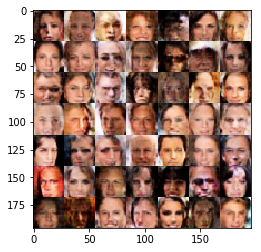

Batch 2710... Discriminator Loss: 0.9141... Generator Loss: 1.9616
Batch 2720... Discriminator Loss: 1.0464... Generator Loss: 2.5728
Batch 2730... Discriminator Loss: 1.8149... Generator Loss: 0.3070
Batch 2740... Discriminator Loss: 0.7890... Generator Loss: 1.1876
Batch 2750... Discriminator Loss: 1.1633... Generator Loss: 1.2460
Batch 2760... Discriminator Loss: 1.3275... Generator Loss: 0.9468
Batch 2770... Discriminator Loss: 1.5175... Generator Loss: 0.6138
Batch 2780... Discriminator Loss: 1.1841... Generator Loss: 1.6415
Batch 2790... Discriminator Loss: 0.7647... Generator Loss: 3.7916
Batch 2800... Discriminator Loss: 1.5898... Generator Loss: 0.4105


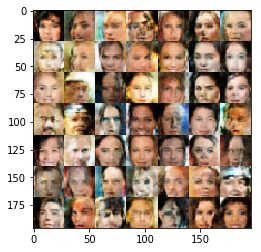

Batch 2810... Discriminator Loss: 1.1941... Generator Loss: 1.8097
Batch 2820... Discriminator Loss: 0.9472... Generator Loss: 1.1009
Batch 2830... Discriminator Loss: 1.3930... Generator Loss: 0.5312
Batch 2840... Discriminator Loss: 1.0189... Generator Loss: 0.8218
Batch 2850... Discriminator Loss: 1.5940... Generator Loss: 0.4035
Batch 2860... Discriminator Loss: 1.1597... Generator Loss: 0.7643
Batch 2870... Discriminator Loss: 1.2147... Generator Loss: 0.6471
Batch 2880... Discriminator Loss: 0.8456... Generator Loss: 1.1086
Batch 2890... Discriminator Loss: 0.7635... Generator Loss: 1.6386
Batch 2900... Discriminator Loss: 1.0909... Generator Loss: 1.7687


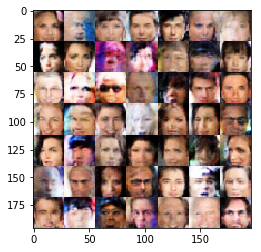

Batch 2910... Discriminator Loss: 0.8389... Generator Loss: 1.4669
Batch 2920... Discriminator Loss: 0.7720... Generator Loss: 1.4547
Batch 2930... Discriminator Loss: 1.2579... Generator Loss: 0.6507
Batch 2940... Discriminator Loss: 2.2270... Generator Loss: 0.1958
Batch 2950... Discriminator Loss: 1.6904... Generator Loss: 0.3853
Batch 2960... Discriminator Loss: 0.8427... Generator Loss: 1.4588
Batch 2970... Discriminator Loss: 2.3306... Generator Loss: 3.2709
Batch 2980... Discriminator Loss: 0.8186... Generator Loss: 1.6970
Batch 2990... Discriminator Loss: 0.7572... Generator Loss: 3.3506
Batch 3000... Discriminator Loss: 1.0978... Generator Loss: 0.7595


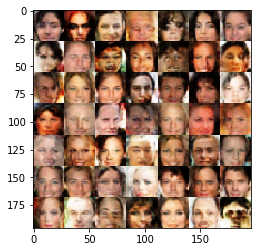

Batch 3010... Discriminator Loss: 0.9075... Generator Loss: 1.1229
Batch 3020... Discriminator Loss: 1.8913... Generator Loss: 0.2695
Batch 3030... Discriminator Loss: 1.0192... Generator Loss: 1.3710
Batch 3040... Discriminator Loss: 1.0719... Generator Loss: 1.0751
Batch 3050... Discriminator Loss: 1.3672... Generator Loss: 0.6352
Batch 3060... Discriminator Loss: 0.7130... Generator Loss: 1.4455
Batch 3070... Discriminator Loss: 1.0355... Generator Loss: 0.8312
Batch 3080... Discriminator Loss: 1.7041... Generator Loss: 1.3723
Batch 3090... Discriminator Loss: 1.7214... Generator Loss: 2.3304
Batch 3100... Discriminator Loss: 0.6342... Generator Loss: 1.7050


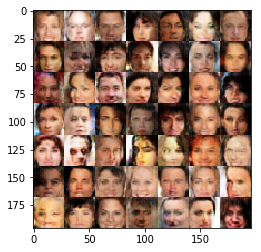

Batch 3110... Discriminator Loss: 1.2316... Generator Loss: 0.9808
Batch 3120... Discriminator Loss: 1.0268... Generator Loss: 1.5277
Batch 3130... Discriminator Loss: 1.1549... Generator Loss: 0.8431
Batch 3140... Discriminator Loss: 1.0356... Generator Loss: 1.1384
Batch 3150... Discriminator Loss: 1.0175... Generator Loss: 0.9438
Batch 3160... Discriminator Loss: 1.2317... Generator Loss: 0.8271
Batch 3170... Discriminator Loss: 1.0899... Generator Loss: 0.7551
Batch 3180... Discriminator Loss: 1.3187... Generator Loss: 1.9580
Batch 3190... Discriminator Loss: 0.8444... Generator Loss: 1.1405
Batch 3200... Discriminator Loss: 1.4412... Generator Loss: 1.8343


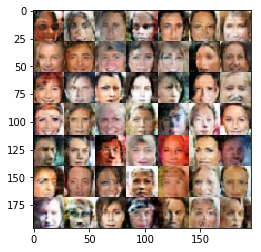

Batch 3210... Discriminator Loss: 1.0301... Generator Loss: 1.0854
Batch 3220... Discriminator Loss: 2.2669... Generator Loss: 0.2009
Batch 3230... Discriminator Loss: 0.5323... Generator Loss: 4.1470
Batch 3240... Discriminator Loss: 1.1861... Generator Loss: 1.0561
Batch 3250... Discriminator Loss: 1.3036... Generator Loss: 0.6553
Batch 3260... Discriminator Loss: 1.5060... Generator Loss: 0.4607
Batch 3270... Discriminator Loss: 1.7221... Generator Loss: 0.3803
Batch 3280... Discriminator Loss: 0.9938... Generator Loss: 0.9141
Batch 3290... Discriminator Loss: 1.4049... Generator Loss: 2.1104
Batch 3300... Discriminator Loss: 0.5175... Generator Loss: 2.8475


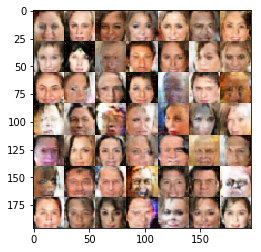

Batch 3310... Discriminator Loss: 0.8703... Generator Loss: 1.1160
Batch 3320... Discriminator Loss: 1.3505... Generator Loss: 0.5372
Batch 3330... Discriminator Loss: 0.9084... Generator Loss: 1.5575
Batch 3340... Discriminator Loss: 1.8230... Generator Loss: 0.3185
Batch 3350... Discriminator Loss: 1.2062... Generator Loss: 0.9077
Batch 3360... Discriminator Loss: 1.2522... Generator Loss: 0.6213
Batch 3370... Discriminator Loss: 1.4445... Generator Loss: 0.5025
Batch 3380... Discriminator Loss: 1.2304... Generator Loss: 0.7252
Batch 3390... Discriminator Loss: 0.6440... Generator Loss: 1.5620
Batch 3400... Discriminator Loss: 0.5111... Generator Loss: 2.5261


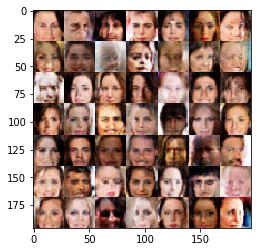

Batch 3410... Discriminator Loss: 1.0371... Generator Loss: 1.3993
Batch 3420... Discriminator Loss: 1.3714... Generator Loss: 0.5223
Batch 3430... Discriminator Loss: 0.9107... Generator Loss: 1.3822
Batch 3440... Discriminator Loss: 1.1232... Generator Loss: 1.1712
Batch 3450... Discriminator Loss: 0.5915... Generator Loss: 2.2507
Batch 3460... Discriminator Loss: 1.2726... Generator Loss: 0.8622
Batch 3470... Discriminator Loss: 1.2106... Generator Loss: 0.7691
Batch 3480... Discriminator Loss: 1.2630... Generator Loss: 0.5994
Batch 3490... Discriminator Loss: 0.9929... Generator Loss: 1.0869
Batch 3500... Discriminator Loss: 1.2080... Generator Loss: 0.7049


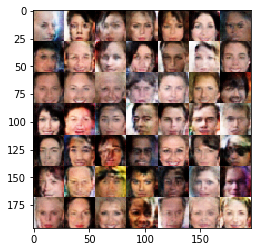

Batch 3510... Discriminator Loss: 1.2975... Generator Loss: 0.7417
Batch 3520... Discriminator Loss: 1.0273... Generator Loss: 1.3423
Batch 3530... Discriminator Loss: 1.5644... Generator Loss: 1.7176
Batch 3540... Discriminator Loss: 1.1690... Generator Loss: 1.2843
Batch 3550... Discriminator Loss: 1.3333... Generator Loss: 1.0810
Batch 3560... Discriminator Loss: 1.2332... Generator Loss: 0.8371
Batch 3570... Discriminator Loss: 1.1050... Generator Loss: 0.8033
Batch 3580... Discriminator Loss: 1.2789... Generator Loss: 0.6269
Batch 3590... Discriminator Loss: 1.4296... Generator Loss: 0.4777
Batch 3600... Discriminator Loss: 1.4483... Generator Loss: 0.4757


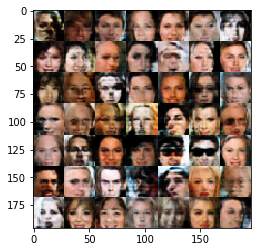

Batch 3610... Discriminator Loss: 0.6184... Generator Loss: 2.3676
Batch 3620... Discriminator Loss: 1.3288... Generator Loss: 0.5887
Batch 3630... Discriminator Loss: 1.1653... Generator Loss: 0.9180
Batch 3640... Discriminator Loss: 0.9294... Generator Loss: 0.9253
Batch 3650... Discriminator Loss: 1.2395... Generator Loss: 0.6425
Batch 3660... Discriminator Loss: 1.6488... Generator Loss: 0.3630
Batch 3670... Discriminator Loss: 1.7572... Generator Loss: 0.3200
Batch 3680... Discriminator Loss: 0.8211... Generator Loss: 1.4838
Batch 3690... Discriminator Loss: 1.0747... Generator Loss: 1.9384
Batch 3700... Discriminator Loss: 1.1225... Generator Loss: 0.9231


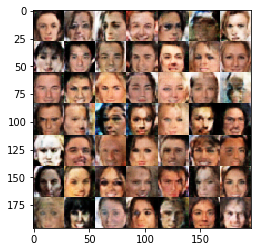

Batch 3710... Discriminator Loss: 1.1787... Generator Loss: 1.1002
Batch 3720... Discriminator Loss: 1.3563... Generator Loss: 0.5321
Batch 3730... Discriminator Loss: 1.4301... Generator Loss: 0.4996
Batch 3740... Discriminator Loss: 1.9598... Generator Loss: 0.2640
Batch 3750... Discriminator Loss: 1.0314... Generator Loss: 1.0274
Batch 3760... Discriminator Loss: 0.7486... Generator Loss: 1.4182
Batch 3770... Discriminator Loss: 1.1940... Generator Loss: 0.6576
Batch 3780... Discriminator Loss: 1.2008... Generator Loss: 1.3049
Batch 3790... Discriminator Loss: 1.2462... Generator Loss: 0.6929
Batch 3800... Discriminator Loss: 1.5119... Generator Loss: 0.4634


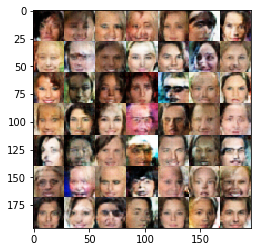

Batch 3810... Discriminator Loss: 1.5476... Generator Loss: 2.1350
Batch 3820... Discriminator Loss: 1.2297... Generator Loss: 0.5941
Batch 3830... Discriminator Loss: 1.1170... Generator Loss: 0.8919
Batch 3840... Discriminator Loss: 1.0735... Generator Loss: 0.8479
Batch 3850... Discriminator Loss: 1.0903... Generator Loss: 1.4848
Batch 3860... Discriminator Loss: 0.9990... Generator Loss: 0.9113
Batch 3870... Discriminator Loss: 1.1112... Generator Loss: 1.2454
Batch 3880... Discriminator Loss: 1.2605... Generator Loss: 0.7163
Batch 3890... Discriminator Loss: 1.2595... Generator Loss: 0.5853
Batch 3900... Discriminator Loss: 1.6138... Generator Loss: 1.7109


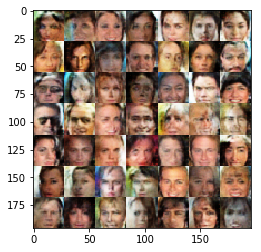

Batch 3910... Discriminator Loss: 0.9044... Generator Loss: 1.1650
Batch 3920... Discriminator Loss: 1.4889... Generator Loss: 0.4686
Batch 3930... Discriminator Loss: 0.7006... Generator Loss: 1.7777
Batch 3940... Discriminator Loss: 1.2536... Generator Loss: 0.6862
Batch 3950... Discriminator Loss: 0.9545... Generator Loss: 1.2329
Batch 3960... Discriminator Loss: 1.2546... Generator Loss: 0.6443
Batch 3970... Discriminator Loss: 1.0724... Generator Loss: 0.8224
Batch 3980... Discriminator Loss: 1.0559... Generator Loss: 0.9491
Batch 3990... Discriminator Loss: 2.0878... Generator Loss: 0.2254
Batch 4000... Discriminator Loss: 1.2540... Generator Loss: 1.1889


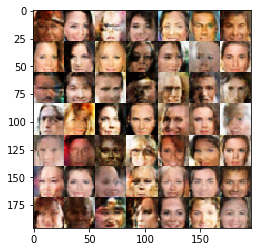

Batch 4010... Discriminator Loss: 1.1523... Generator Loss: 0.7603
Batch 4020... Discriminator Loss: 1.1319... Generator Loss: 0.7721
Batch 4030... Discriminator Loss: 1.2735... Generator Loss: 0.6225
Batch 4040... Discriminator Loss: 1.0564... Generator Loss: 0.7922
Batch 4050... Discriminator Loss: 1.2419... Generator Loss: 0.7616
Batch 4051

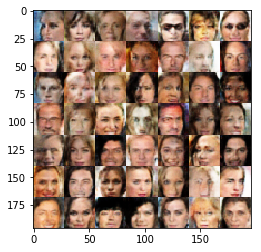

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5835


In [13]:
batch_size = 50
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.